In [1]:
import pickle
import pm4py
import pm4py.ocel
import random
from copy import copy
import torch_geometric as tg
import torch_geometric.utils as utils
from torch_geometric.data import HeteroData
import torch
from pm4py.algo.transformation.ocel.features.objects import algorithm as object_feature_factory
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

ocel_file =  "../../data/BPI17/BPI2017-Final.jsonocel"

/home/tim/Development/OCPPM/.env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ocel = pm4py.read.read_ocel(ocel_file)
ocel.objects.dtypes

ocel:oid                        object
ocel:type                       object
event_RequestedAmount          float64
event_LoanGoal                  object
event_ApplicationType           object
event_OfferedAmount            float64
event_NumberOfTerms            float64
event_CreditScore              float64
event_Accepted                  object
event_FirstWithdrawalAmount    float64
event_MonthlyCost              float64
event_Selected                  object
dtype: object

In [3]:
ocel.objects['event_Accepted'] = ocel.objects['event_Accepted'].replace({True: 1, False: 0})
ocel.objects['event_Selected'] = ocel.objects['event_Selected'].replace({True: 1, False: 0})
ocel.objects = ocel.objects.reset_index().rename(columns={'index':'object_index'})
ocel.objects.head()

,object_index,ocel:oid,ocel:type,event_RequestedAmount,event_LoanGoal,event_ApplicationType,event_OfferedAmount,event_NumberOfTerms,event_CreditScore,event_Accepted,event_FirstWithdrawalAmount,event_MonthlyCost,event_Selected
0,0,Application_652823628,application,20000.0,Existing loan takeover,New credit,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Offer_148581083,offer,NaN,NaN,NaN,20000.0,44.0,979.0,1.0,20000.0,498.29,1.0
2,2,Application_1691306052,application,10000.0,Home improvement,New credit,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,Offer_1669071500,offer,NaN,NaN,NaN,6000.0,33.0,0.0,0.0,500.0,200.00,0.0
4,4,Application_428409768,application,15000.0,Home improvement,New credit,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
offer_attributes = {
    "str": [],
    "num": [
        "event_Accepted",
        "event_Selected",
        "event_OfferedAmount",
        "event_NumberOfTerms",
        "event_CreditScore",
        "event_FirstWithdrawalAmount",
        "event_MonthlyCost",
    ],
}
application_attributes = {
    "str": [
        "event_LoanGoal",
        "event_ApplicationType",
    ],
    "num": [
        "event_RequestedAmount",
    ],
}

In [5]:
data, feature_names = object_feature_factory.apply(
    ocel,
    parameters={
        "str_obj_attr": ["ocel:type"]
        + application_attributes["str"]
        + offer_attributes["str"],
        "num_obj_attr": ["object_index"]
        + application_attributes["num"]
        + offer_attributes["num"],
    },
)

In [6]:
object_features = pd.DataFrame(data,columns=feature_names)
object_index_map = pd.Series(ocel.objects["object_index"].values,index=ocel.objects["ocel:oid"]).to_dict()
# object_features.replace(object_index_map)


In [7]:
object_features = object_features.rename(columns={'@@event_num_object_index':'oid'})
object_features['oid'] = object_features['oid'].astype(int)
object_features['oid'] = object_features['oid'].replace(object_index_map)

In [8]:
# Split object feature matrix into one feature matrix per object type
offer_features = object_features[
    object_features["@@object_attr_value_ocel:type_offer"] == 1
]
application_features = object_features[
    object_features["@@object_attr_value_ocel:type_application"] == 1
]

# Take only object attribute features, excluding object interaction features
flatten = lambda l: [item for sublist in l for item in sublist]
application_attribute_feature_idxs = flatten(
    [
        np.where(application_features.columns.str.contains(attr_name))[0]
        for attr_name in application_attributes["str"]
        + application_attributes["num"]
        + ["oid"]
    ]
)
offer_attribute_feature_idxs = flatten(
    [
        np.where(offer_features.columns.str.contains(attr_name))[0]
        for attr_name in offer_attributes["str"]
        + offer_attributes["num"]
        + ["oid"]
    ]
)
application_features = application_features.iloc[:, application_attribute_feature_idxs]
offer_features = offer_features.iloc[:, offer_attribute_feature_idxs]


In [9]:
graph = pm4py.ocel.discover_objects_graph(ocel, graph_type="object_interaction")
graph = {(object_index_map[edge[0]],object_index_map[edge[1]]) for edge in graph}

In [10]:
with open('../../data/BPI17/ocpa-processed/object_interaction_graph.pkl','wb') as f:
    pickle.dump(graph, f)


In [11]:
offer_fts_sample = torch.tensor(offer_features.iloc[:5, :-1].values)
application_fts_sample = torch.tensor(application_features.iloc[:5, :-1].values)
print('offer_fts_sample')
print(offer_fts_sample)
print('application_fts_sample')
print(application_fts_sample)

offer_fts_sample
tensor([[1.0000e+00, 1.0000e+00, 2.0000e+04, 4.4000e+01, 9.7900e+02, 2.0000e+04,
         4.9829e+02],
        [0.0000e+00, 0.0000e+00, 6.0000e+03, 3.3000e+01, 0.0000e+00, 5.0000e+02,
         2.0000e+02],
        [1.0000e+00, 0.0000e+00, 1.5000e+04, 1.2000e+02, 0.0000e+00, 1.5000e+04,
         1.5898e+02],
        [1.0000e+00, 1.0000e+00, 1.5000e+04, 1.2000e+02, 1.0590e+03, 1.5000e+04,
         1.5898e+02],
        [0.0000e+00, 1.0000e+00, 1.5700e+04, 7.2000e+01, 8.3400e+02, 3.7260e+03,
         2.5273e+02]], dtype=torch.float64)
application_fts_sample
tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 2.0000e+04],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+

In [12]:
hetero_data = HeteroData()
hetero_data["offer"].x = torch.tensor(offer_features.iloc[:, :-1].values)
hetero_data["application"].x = torch.tensor(application_features.iloc[:, :-1].values)
hetero_data["application", "interacts with", "application"].edge_index = graph
hetero_data["application", "interacts with", "offer"].edge_index = graph
hetero_data["offer", "interacts with", "offer"].edge_index = graph
hetero_data

# uitvogelen hoe de objecten indiceer, zodat ik ze kan herleiden naar het oorspronkelijke object id in de OCEL

HeteroData(
  offer={ x=[42995, 7] },
  application={ x=[31509, 17] },
  (application, interacts with, application)={ edge_index={(3014, 3015), (16623, 16624), (17483, 17482), (60709, 60710), (39619, 39620), (5859, 5860), (7765, 7766), (51851, 51852), (6388, 6389), (35254, 35255), (58250, 58251), (62983, 62985), (47486, 47487), (26396, 26397), (64889, 64891), (10039, 10041), (20526, 20527), (49392, 49393), (25019, 25020), (16401, 16403), (35266, 35265), (54468, 54466), (39157, 39158), (7543, 7545), (28393, 28394), (37780, 37781), (51389, 51390), (21423, 21425), (67506, 67505), (3178, 3180), (36938, 36940), (42531, 42532), (44179, 44180), (57788, 57789), (65527, 65528), (49170, 49172), (33673, 33674), (70020, 70021), (20924, 20923), (32573, 32575), (71926, 71927), (11206, 11207), (24815, 24816), (47553, 47554), (442, 443), (70549, 70550), (9829, 9830), (25086, 25087), (24298, 24297), (38695, 38696), (971, 972), (16228, 16229), (50927, 50928), (52833, 52834), (22867, 22869), (28460, 2846

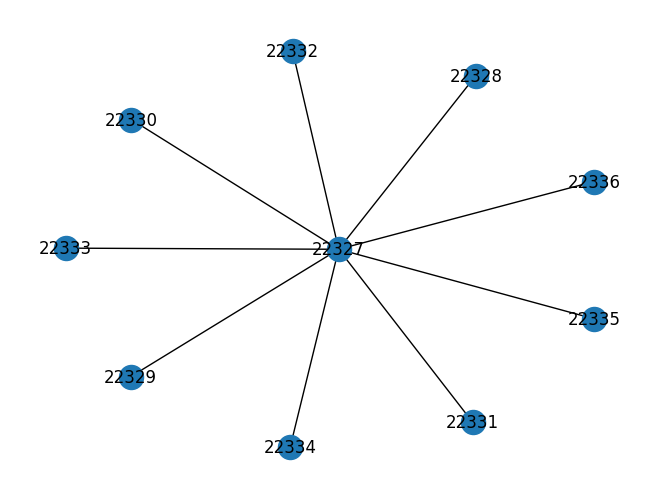

In [13]:
G = nx.Graph()
G.add_edges_from(graph)
some_graph = {x for x in graph if 'Application_2114646933' in x }
sorted_cc = sorted(list(nx.connected_components(G)), key=len, reverse=True)
sg = G.subgraph(sorted_cc[4])
# sg = nx.Graph()
# sg.add_edges_from(some_graph_adjacency)
nx.draw(sg, with_labels = True)
plt.savefig("../../tests/objects_interaction_graph.png")

In [14]:
from torch_geometric.datasets import OGB_MAG

dataset = OGB_MAG(root='./data', preprocess='metapath2vec')
citation_network = dataset[0]
citation_network

HeteroData(
  paper={
    x=[736389, 128],
    year=[736389],
    y=[736389],
    train_mask=[736389],
    val_mask=[736389],
    test_mask=[736389]
  },
  author={ x=[1134649, 128] },
  institution={ x=[8740, 128] },
  field_of_study={ x=[59965, 128] },
  (author, affiliated_with, institution)={ edge_index=[2, 1043998] },
  (author, writes, paper)={ edge_index=[2, 7145660] },
  (paper, cites, paper)={ edge_index=[2, 5416271] },
  (paper, has_topic, field_of_study)={ edge_index=[2, 7505078] }
)

In [15]:
example_edge = citation_network.edge_items()[0]
edge_tensor = example_edge[1].edge_index

In [16]:
edge_tensor.shape

torch.Size([2, 1043998])

In [17]:
# testing to check whether we can indicate correct nodes from each node type in the edge_index
orders = {"price": [1250, 678], "discount": [33, 0], "black_friday_sale":[1, 0]}
items = {"weight": [3.5, 3.0, 26.0], "size": [2, 2, 3]}
order_x_tensor = torch.tensor(list(orders.values()))[1:].T
order_y_tensor = torch.tensor(list(orders.values()))[0].T # order_price will be the target
item_x_tensor = torch.tensor(list(items.values())).T
o_o_interaction = torch.tensor([[],[]])
o_i_interaction = torch.tensor([[0,0,2, 2,3,3],[2,3,3, 0,0,2]])
i_i_interaction = torch.tensor([[3, 4],[4, 3]])
test_het = HeteroData({'order': {'x': order_x_tensor, 'y': order_y_tensor}, 'item': {'x': item_x_tensor}}, 
                  order__interacts_with__order={'edge_index': o_o_interaction}, 
                  order__interacts_with__item={'edge_index': o_i_interaction}, 
                  item__interacts_with__item={'edge_index': i_i_interaction})

/tmp/ipykernel_26442/3690366266.py:5: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3277.)
  order_y_tensor = torch.tensor(list(orders.values()))[0].T # order_price will be the target


In [18]:
test_het = HeteroData({'order': {'x': order_x_tensor, 'y': order_y_tensor}, 'item': {'x': item_x_tensor}}, 
                  order__interacts_with__order={'edge_index': o_o_interaction}, 
                  order__interacts_with__item={'edge_index': o_i_interaction}, 
                  item__interacts_with__item={'edge_index': i_i_interaction})

In [19]:
utils.convert.to_dgl(test_het)

OSError: libcusparse.so.11: cannot open shared object file: No such file or directory

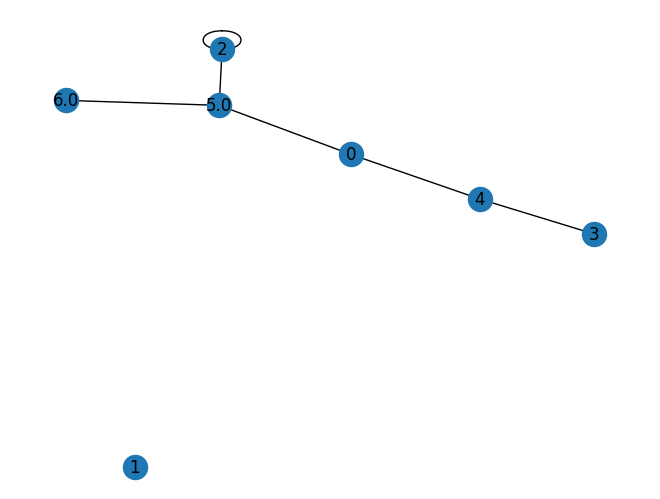

In [141]:
g = utils.to_networkx(test_het.to_homogeneous(), to_undirected=True)
nx.draw(g, with_labels=True)

In [13]:
# define a format for the adjacency matrix (use real oid or custom object_index?)

In [14]:
# Define HeteroData in PyG, using offer_features, application_features, and the adjacency matrix

In [15]:
# build OFG class that can hold features
# enable this class to be ported to PyG
